In [14]:
import sys
sys.path.append('../RecSysRep/')

In [15]:
import Basics.Load as ld

URM_all, _, _, _, _ = ld.getCOOs()
ICM_weighted = ld.getICMselected('7')
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [16]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=2222)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13647 ( 0.0%) Users that have less than 1 test interactions


In [17]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {"num_factors": 29, "epochs": 50, "confidence_scaling": "log", "alpha": 0.001, "epsilon": 0.001, "reg": 0.01},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_weighted': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True}
                         }


In [18]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [19]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

In [20]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal

In [21]:
recommender_3 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
recommender_4 = SLIM_BPR_Cython(URM_train)
recommender_1 = RP3betaRecommender(URM_train)
recommender_2 = ItemKNNCBFRecommender(URM_train, ICM_weighted)

model_init(recommender_3, 'SLIM_Pure', models_to_combine_best['SLIMER'])
model_init(recommender_4, 'SLIM_BPR', models_to_combine_best['SLIMBPR'])
model_init(recommender_1, 'RP3beta', models_to_combine_best['RP3beta'])
model_init(recommender_2, 'KNNweigh', models_to_combine_best['icm_weighted'])

recommender1 = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_3.W_sparse, recommender_4.W_sparse)
recommender1.fit(0.9876793526315789)

recommender2 = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
recommender2.fit(0.9546136842105264)

ItemKNNCBFRecommender: ICM Detected 22 ( 0.1%) items with no features.
../models_temp/Similarity_Hybrid/SLIM_Pure.zip
Model does not exists, creating...


100%|███████████████████████████████████████████████████████████████████████████▉| 18056/18059 [30:54<00:00,  9.74it/s]


SLIMElasticNetRecommender: Saving model in file '../models_temp/Similarity_Hybrid/SLIM_Pure'
SLIMElasticNetRecommender: Saving complete
../models_temp/Similarity_Hybrid/SLIM_BPR.zip
Model does not exists, creating...
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 13650 (100.0%) in 1.76 sec. BPR loss is 1.10E+00. Sample per second: 7738
SLIM_BPR_Recommender: Epoch 1 of 440. Elapsed time 1.41 sec
Processed 13650 (100.0%) in 2.06 sec. BPR loss is 3.47E+00. Sample per second: 6632
SLIM_BPR_Recommender: Epoch 2 of 440. Elapsed time 2.71 sec
Processed 13650 (100.0%) in 1.33 sec. BPR loss is 5.29E+00. Sample per second: 10260
SLIM_BPR_Recommender: Epoch 3 of 440. Elapsed time 3.98 sec
Processed 13650 (100.0%) in 1.59 sec. BPR loss is 6.63E+00. Sample per second: 8597
SLIM_BPR_Recommender: Epoch 4 of 440. Elapsed 

SLIM_BPR_Recommender: Epoch 54 of 440. Elapsed time 1.56 min
Processed 13650 (100.0%) in 1.93 sec. BPR loss is 2.22E+01. Sample per second: 7081
SLIM_BPR_Recommender: Epoch 55 of 440. Elapsed time 1.58 min
Processed 13650 (100.0%) in 3.44 sec. BPR loss is 2.29E+01. Sample per second: 3970
SLIM_BPR_Recommender: Epoch 56 of 440. Elapsed time 1.62 min
Processed 13650 (100.0%) in 2.24 sec. BPR loss is 2.34E+01. Sample per second: 6086
SLIM_BPR_Recommender: Epoch 57 of 440. Elapsed time 1.65 min
Processed 13650 (100.0%) in 1.91 sec. BPR loss is 2.41E+01. Sample per second: 7146
SLIM_BPR_Recommender: Epoch 58 of 440. Elapsed time 1.68 min
Processed 13650 (100.0%) in 2.47 sec. BPR loss is 2.35E+01. Sample per second: 5516
SLIM_BPR_Recommender: Epoch 59 of 440. Elapsed time 1.70 min
Processed 13650 (100.0%) in 1.47 sec. BPR loss is 2.40E+01. Sample per second: 9271
SLIM_BPR_Recommender: Epoch 60 of 440. Elapsed time 1.72 min
Processed 13650 (100.0%) in 1.84 sec. BPR loss is 2.33E+01. Sample pe

Processed 13650 (100.0%) in 2.78 sec. BPR loss is 2.74E+01. Sample per second: 4904
SLIM_BPR_Recommender: Epoch 111 of 440. Elapsed time 3.17 min
Processed 13650 (100.0%) in 2.16 sec. BPR loss is 2.71E+01. Sample per second: 6309
SLIM_BPR_Recommender: Epoch 112 of 440. Elapsed time 3.20 min
Processed 13650 (100.0%) in 1.64 sec. BPR loss is 2.79E+01. Sample per second: 8333
SLIM_BPR_Recommender: Epoch 113 of 440. Elapsed time 3.22 min
Processed 13650 (100.0%) in 2.38 sec. BPR loss is 2.79E+01. Sample per second: 5746
SLIM_BPR_Recommender: Epoch 114 of 440. Elapsed time 3.25 min
Processed 13650 (100.0%) in 2.12 sec. BPR loss is 2.73E+01. Sample per second: 6449
SLIM_BPR_Recommender: Epoch 115 of 440. Elapsed time 3.28 min
Processed 13650 (100.0%) in 1.69 sec. BPR loss is 2.67E+01. Sample per second: 8100
SLIM_BPR_Recommender: Epoch 116 of 440. Elapsed time 3.31 min
Processed 13650 (100.0%) in 2.25 sec. BPR loss is 2.75E+01. Sample per second: 6063
SLIM_BPR_Recommender: Epoch 117 of 440. 

SLIM_BPR_Recommender: Epoch 167 of 440. Elapsed time 4.70 min
Processed 13650 (100.0%) in 2.28 sec. BPR loss is 2.96E+01. Sample per second: 5986
SLIM_BPR_Recommender: Epoch 168 of 440. Elapsed time 4.73 min
Processed 13650 (100.0%) in 1.88 sec. BPR loss is 2.89E+01. Sample per second: 7255
SLIM_BPR_Recommender: Epoch 169 of 440. Elapsed time 4.76 min
Processed 13650 (100.0%) in 2.54 sec. BPR loss is 2.91E+01. Sample per second: 5376
SLIM_BPR_Recommender: Epoch 170 of 440. Elapsed time 4.79 min
Processed 13650 (100.0%) in 2.14 sec. BPR loss is 2.98E+01. Sample per second: 6384
SLIM_BPR_Recommender: Epoch 171 of 440. Elapsed time 4.81 min
Processed 13650 (100.0%) in 1.39 sec. BPR loss is 2.94E+01. Sample per second: 9806
SLIM_BPR_Recommender: Epoch 172 of 440. Elapsed time 4.83 min
Processed 13650 (100.0%) in 1.76 sec. BPR loss is 2.96E+01. Sample per second: 7769
SLIM_BPR_Recommender: Epoch 173 of 440. Elapsed time 4.86 min
Processed 13650 (100.0%) in 2.10 sec. BPR loss is 2.92E+01. Sa

Processed 13650 (100.0%) in 1.87 sec. BPR loss is 3.16E+01. Sample per second: 7297
SLIM_BPR_Recommender: Epoch 224 of 440. Elapsed time 6.39 min
Processed 13650 (100.0%) in 2.53 sec. BPR loss is 3.07E+01. Sample per second: 5390
SLIM_BPR_Recommender: Epoch 225 of 440. Elapsed time 6.42 min
Processed 13650 (100.0%) in 2.21 sec. BPR loss is 3.05E+01. Sample per second: 6169
SLIM_BPR_Recommender: Epoch 226 of 440. Elapsed time 6.45 min
Processed 13650 (100.0%) in 1.36 sec. BPR loss is 3.05E+01. Sample per second: 10002
SLIM_BPR_Recommender: Epoch 227 of 440. Elapsed time 6.47 min
Processed 13650 (100.0%) in 1.64 sec. BPR loss is 3.06E+01. Sample per second: 8305
SLIM_BPR_Recommender: Epoch 228 of 440. Elapsed time 6.49 min
Processed 13650 (100.0%) in 1.57 sec. BPR loss is 3.08E+01. Sample per second: 8675
SLIM_BPR_Recommender: Epoch 229 of 440. Elapsed time 6.50 min
Processed 13650 (100.0%) in 1.80 sec. BPR loss is 3.08E+01. Sample per second: 7602
SLIM_BPR_Recommender: Epoch 230 of 440.

SLIM_BPR_Recommender: Epoch 280 of 440. Elapsed time 7.97 min
Processed 13650 (100.0%) in 3.94 sec. BPR loss is 3.14E+01. Sample per second: 3462
SLIM_BPR_Recommender: Epoch 281 of 440. Elapsed time 8.03 min
Processed 13650 (100.0%) in 3.88 sec. BPR loss is 3.24E+01. Sample per second: 3520
SLIM_BPR_Recommender: Epoch 282 of 440. Elapsed time 8.08 min
Processed 13650 (100.0%) in 3.45 sec. BPR loss is 3.18E+01. Sample per second: 3958
SLIM_BPR_Recommender: Epoch 283 of 440. Elapsed time 8.12 min
Processed 13650 (100.0%) in 2.38 sec. BPR loss is 3.11E+01. Sample per second: 5727
SLIM_BPR_Recommender: Epoch 284 of 440. Elapsed time 8.15 min
Processed 13650 (100.0%) in 1.65 sec. BPR loss is 3.23E+01. Sample per second: 8292
SLIM_BPR_Recommender: Epoch 285 of 440. Elapsed time 8.17 min
Processed 13650 (100.0%) in 2.21 sec. BPR loss is 3.20E+01. Sample per second: 6167
SLIM_BPR_Recommender: Epoch 286 of 440. Elapsed time 8.20 min
Processed 13650 (100.0%) in 2.46 sec. BPR loss is 3.12E+01. Sa

Processed 13650 (100.0%) in 1.32 sec. BPR loss is 3.25E+01. Sample per second: 10322
SLIM_BPR_Recommender: Epoch 337 of 440. Elapsed time 9.93 min
Processed 13650 (100.0%) in 2.02 sec. BPR loss is 3.23E+01. Sample per second: 6760
SLIM_BPR_Recommender: Epoch 338 of 440. Elapsed time 9.96 min
Processed 13650 (100.0%) in 1.68 sec. BPR loss is 3.24E+01. Sample per second: 8102
SLIM_BPR_Recommender: Epoch 339 of 440. Elapsed time 9.99 min
Processed 13650 (100.0%) in 2.22 sec. BPR loss is 3.24E+01. Sample per second: 6155
SLIM_BPR_Recommender: Epoch 340 of 440. Elapsed time 10.01 min
Processed 13650 (100.0%) in 1.79 sec. BPR loss is 3.28E+01. Sample per second: 7605
SLIM_BPR_Recommender: Epoch 341 of 440. Elapsed time 10.04 min
Processed 13650 (100.0%) in 1.88 sec. BPR loss is 3.27E+01. Sample per second: 7251
SLIM_BPR_Recommender: Epoch 342 of 440. Elapsed time 10.06 min
Processed 13650 (100.0%) in 2.34 sec. BPR loss is 3.28E+01. Sample per second: 5846
SLIM_BPR_Recommender: Epoch 343 of 4

Processed 13650 (100.0%) in 1.81 sec. BPR loss is 3.30E+01. Sample per second: 7527
SLIM_BPR_Recommender: Epoch 393 of 440. Elapsed time 11.61 min
Processed 13650 (100.0%) in 2.01 sec. BPR loss is 3.25E+01. Sample per second: 6780
SLIM_BPR_Recommender: Epoch 394 of 440. Elapsed time 11.63 min
Processed 13650 (100.0%) in 1.29 sec. BPR loss is 3.38E+01. Sample per second: 10590
SLIM_BPR_Recommender: Epoch 395 of 440. Elapsed time 11.65 min
Processed 13650 (100.0%) in 1.21 sec. BPR loss is 3.35E+01. Sample per second: 11268
SLIM_BPR_Recommender: Epoch 396 of 440. Elapsed time 11.66 min
Processed 13650 (100.0%) in 1.55 sec. BPR loss is 3.21E+01. Sample per second: 8783
SLIM_BPR_Recommender: Epoch 397 of 440. Elapsed time 11.69 min
Processed 13650 (100.0%) in 2.39 sec. BPR loss is 3.36E+01. Sample per second: 5698
SLIM_BPR_Recommender: Epoch 398 of 440. Elapsed time 11.72 min
Processed 13650 (100.0%) in 2.58 sec. BPR loss is 3.31E+01. Sample per second: 5296
SLIM_BPR_Recommender: Epoch 399 

In [22]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [23]:
rank_models(evaluator_validation, [recommender1, recommender2])

EvaluatorHoldout: Processed 13647 (100.0%) in 1.26 min. Users per second: 180
ItemKNNSimilarityHybridRecommender 0.24783960891457035
EvaluatorHoldout: Processed 13647 (100.0%) in 45.21 sec. Users per second: 302
ItemKNNSimilarityHybridRecommender 0.22224103559012384


In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, high, low, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(high, low, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

EvaluatorHoldout: Processed 13647 (100.0%) in 38.56 sec. Users per second: 354
0.0 : 0.22224103559012384
EvaluatorHoldout: Processed 13647 (100.0%) in 1.03 min. Users per second: 220
0.041666666666666664 : 0.23323794926729705
EvaluatorHoldout: Processed 13647 (100.0%) in 1.06 min. Users per second: 215
0.08333333333333333 : 0.2387387483265688
EvaluatorHoldout: Processed 13647 (100.0%) in 1.11 min. Users per second: 205
0.125 : 0.2418493540646751
EvaluatorHoldout: Processed 13647 (100.0%) in 1.14 min. Users per second: 200
0.16666666666666666 : 0.24375619212781208
EvaluatorHoldout: Processed 13647 (100.0%) in 1.10 min. Users per second: 206
0.20833333333333331 : 0.2451804571270388
EvaluatorHoldout: Processed 13647 (100.0%) in 1.13 min. Users per second: 200
0.25 : 0.24593434105524786
EvaluatorHoldout: Processed 13647 (100.0%) in 1.14 min. Users per second: 199
0.29166666666666663 : 0.24673363585926858
EvaluatorHoldout: Processed 13647 (100.0%) in 1.08 min. Users per second: 210
0.333333

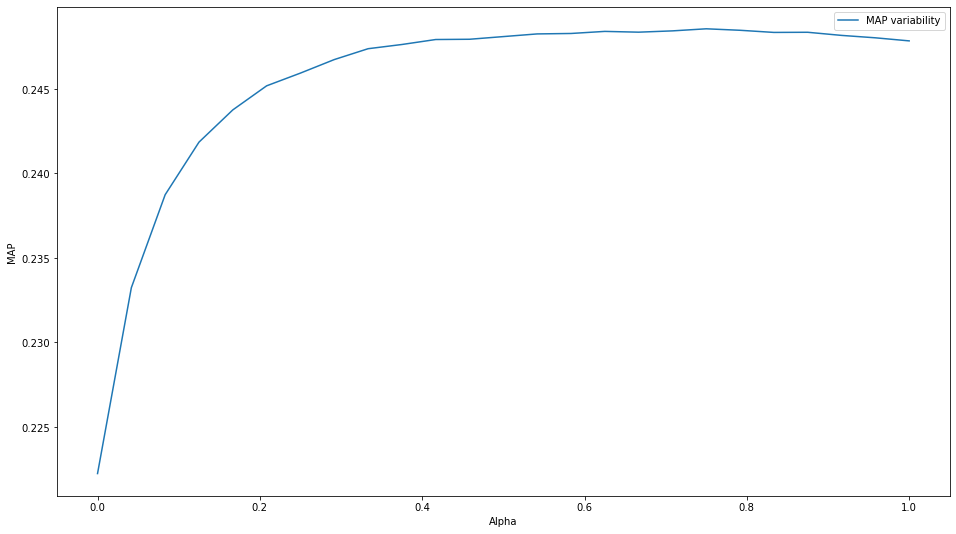

In [26]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0, 1, 25)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13647 (100.0%) in 1.01 min. Users per second: 225
0.7083 : 0.24842792066632569
EvaluatorHoldout: Processed 13647 (100.0%) in 59.52 sec. Users per second: 229
0.7135083333333334 : 0.2484234048764725
EvaluatorHoldout: Processed 13647 (100.0%) in 59.94 sec. Users per second: 228
0.7187166666666667 : 0.24843880159718895
EvaluatorHoldout: Processed 13647 (100.0%) in 58.40 sec. Users per second: 234
0.723925 : 0.24844142151132761
EvaluatorHoldout: Processed 13647 (100.0%) in 58.83 sec. Users per second: 232
0.7291333333333334 : 0.24845092415217748
EvaluatorHoldout: Processed 13647 (100.0%) in 58.49 sec. Users per second: 233
0.7343416666666667 : 0.24849793721743635
EvaluatorHoldout: Processed 13647 (100.0%) in 1.08 min. Users per second: 210
0.73955 : 0.2485541679606313
EvaluatorHoldout: Processed 13647 (100.0%) in 1.16 min. Users per second: 195
0.7447583333333334 : 0.24854750622556773
EvaluatorHoldout: Processed 13647 (100.0%) in 1.17 min. Users per second: 195


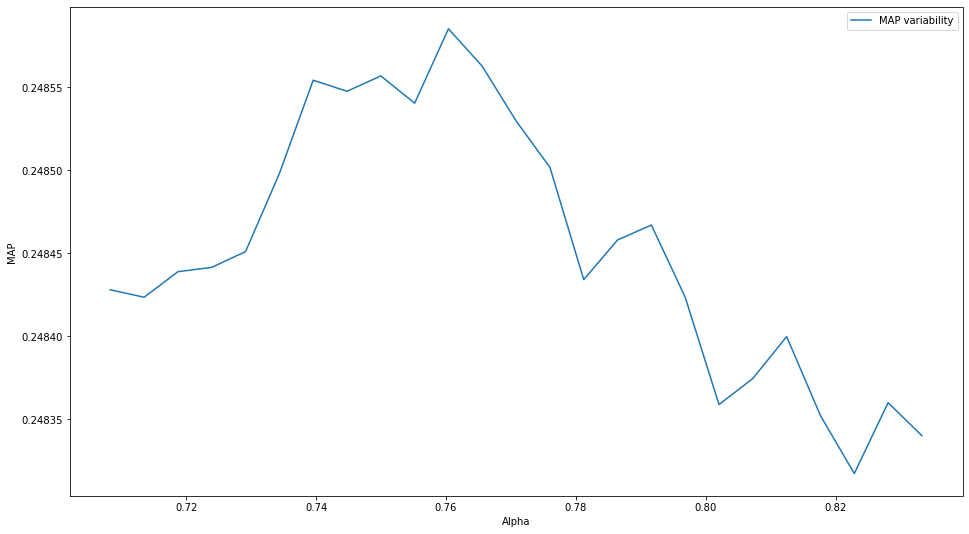

In [29]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.7083, 0.8333, 25)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [17]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.98125, 0.98958334, 25)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13643 (100.0%) in 1.20 min. Users per second: 189
0.98125 : 0.25043834037805346
EvaluatorHoldout: Processed 13643 (100.0%) in 1.42 min. Users per second: 160
0.9815972224999999 : 0.25046668795789256
EvaluatorHoldout: Processed 13643 (100.0%) in 1.28 min. Users per second: 178
0.981944445 : 0.2504699223626517
EvaluatorHoldout: Processed 13643 (100.0%) in 1.23 min. Users per second: 184
0.9822916675 : 0.2505220800480275
EvaluatorHoldout: Processed 13643 (100.0%) in 1.31 min. Users per second: 174
0.9826388899999999 : 0.25055718439248464
EvaluatorHoldout: Processed 13643 (100.0%) in 1.37 min. Users per second: 166
0.9829861125 : 0.2505114024402307
EvaluatorHoldout: Processed 13643 (100.0%) in 1.23 min. Users per second: 185
0.983333335 : 0.2505821637702456
EvaluatorHoldout: Processed 13643 (100.0%) in 1.15 min. Users per second: 197
0.9836805574999999 : 0.2505890136112596
EvaluatorHoldout: Processed 13643 (100.0%) in 1.14 min. Users per second: 200
0.98402778 :

KeyboardInterrupt: 

In [18]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.98368, 0.984373, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13643 (100.0%) in 1.09 min. Users per second: 208
0.98368 : 0.25058860640202735
EvaluatorHoldout: Processed 13643 (100.0%) in 57.55 sec. Users per second: 237
0.9837164736842106 : 0.2505808112538673
EvaluatorHoldout: Processed 13643 (100.0%) in 51.51 sec. Users per second: 265
0.983752947368421 : 0.2505576061449039
EvaluatorHoldout: Processed 13643 (100.0%) in 55.53 sec. Users per second: 246
0.9837894210526316 : 0.2505524927604019
EvaluatorHoldout: Processed 13643 (100.0%) in 57.72 sec. Users per second: 236
0.9838258947368421 : 0.25057257981010117
EvaluatorHoldout: Processed 13643 (100.0%) in 54.64 sec. Users per second: 250
0.9838623684210527 : 0.25056620698561655
EvaluatorHoldout: Processed 13643 (100.0%) in 52.76 sec. Users per second: 259
0.9838988421052631 : 0.2505785570599033
EvaluatorHoldout: Processed 13643 (100.0%) in 52.35 sec. Users per second: 261
0.9839353157894737 : 0.2505665618393764
EvaluatorHoldout: Processed 13643 (100.0%) in 54.36 sec. U

KeyboardInterrupt: 

In [19]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.98715, 0.98785, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13643 (100.0%) in 52.35 sec. Users per second: 261
0.98715 : 0.25069503635215035
EvaluatorHoldout: Processed 13643 (100.0%) in 49.52 sec. Users per second: 276
0.9871868421052631 : 0.2507210046666183
EvaluatorHoldout: Processed 13643 (100.0%) in 50.63 sec. Users per second: 269
0.9872236842105263 : 0.2507371272435777
EvaluatorHoldout: Processed 13643 (100.0%) in 50.37 sec. Users per second: 271
0.9872605263157894 : 0.2507209726716071
EvaluatorHoldout: Processed 13643 (100.0%) in 54.88 sec. Users per second: 249
0.9872973684210526 : 0.2507215049522463
EvaluatorHoldout: Processed 13643 (100.0%) in 50.96 sec. Users per second: 268
0.9873342105263158 : 0.25074898575814847
EvaluatorHoldout: Processed 13643 (100.0%) in 51.00 sec. Users per second: 268
0.987371052631579 : 0.25075794145262054
EvaluatorHoldout: Processed 13643 (100.0%) in 51.11 sec. Users per second: 267
0.9874078947368421 : 0.25074977399887655
EvaluatorHoldout: Processed 13643 (100.0%) in 50.53 sec.

KeyboardInterrupt: 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.00 min. Users per second: 227
0.987629 : 0.25075903219163564
EvaluatorHoldout: Processed 13643 (100.0%) in 1.07 min. Users per second: 212
0.9876328578947369 : 0.25077251663449773
EvaluatorHoldout: Processed 13643 (100.0%) in 1.04 min. Users per second: 219
0.9876367157894737 : 0.250768427090351
EvaluatorHoldout: Processed 13643 (100.0%) in 1.01 min. Users per second: 225
0.9876405736842105 : 0.2507644800694356
EvaluatorHoldout: Processed 13643 (100.0%) in 57.71 sec. Users per second: 236
0.9876444315789473 : 0.2507654951838788
EvaluatorHoldout: Processed 13643 (100.0%) in 59.31 sec. Users per second: 230
0.9876482894736842 : 0.25076256909468136
EvaluatorHoldout: Processed 13643 (100.0%) in 1.00 min. Users per second: 227
0.987652147368421 : 0.2507656667934837
EvaluatorHoldout: Processed 13643 (100.0%) in 1.07 min. Users per second: 212
0.9876560052631579 : 0.2507603643475524
EvaluatorHoldout: Processed 13643 (100.0%) in 1.03 min. Users p

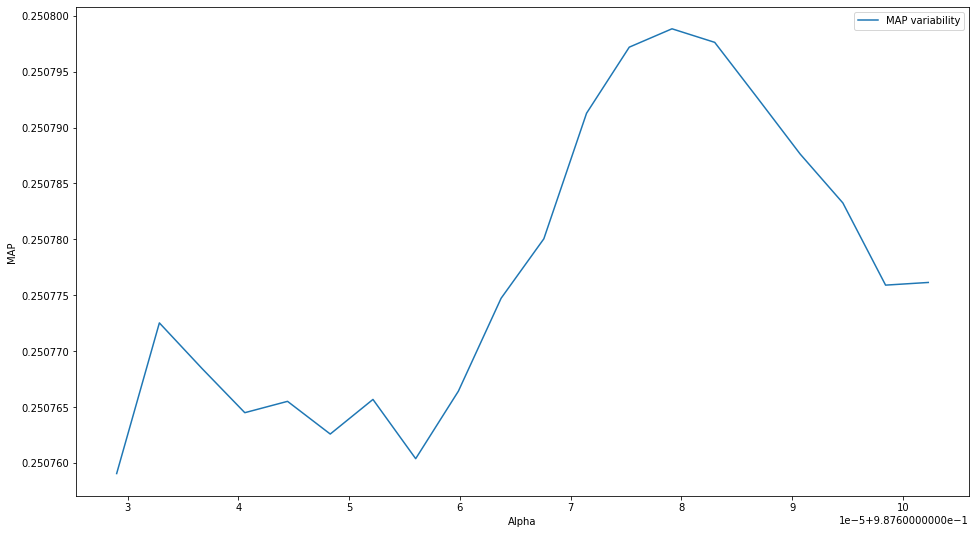

In [20]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.987629, 0.9877023, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [ ]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.9876300, 0.9876367, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [ ]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.9876753, 0.987683, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('Alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13643 (100.0%) in 1.03 min. Users per second: 222
0.9876753 : 0.2507971935139718
EvaluatorHoldout: Processed 13643 (100.0%) in 1.00 min. Users per second: 227
0.987675705263158 : 0.25079462809580866
EvaluatorHoldout: Processed 13643 (100.0%) in 58.59 sec. Users per second: 233
0.9876761105263158 : 0.25079568683981246
EvaluatorHoldout: Processed 13643 (100.0%) in 58.20 sec. Users per second: 234
0.9876765157894737 : 0.2507908963140588
EvaluatorHoldout: Processed 13643 (100.0%) in 57.75 sec. Users per second: 236
0.9876769210526316 : 0.25078943036082274
EvaluatorHoldout: Processed 13643 (100.0%) in 1.04 min. Users per second: 218
0.9876773263157895 : 0.25078943036082274
EvaluatorHoldout: Processed 13643 (100.0%) in 1.02 min. Users per second: 223
0.9876777315789473 : 0.2507891453143602
EvaluatorHoldout: Processed 13643 (100.0%) in 58.93 sec. Users per second: 231
0.9876781368421053 : 0.2507891453143602
EvaluatorHoldout: Processed 13643 (100.0%) in 58.48 sec. U